In [1]:
import sys
sys.path.append("..")

import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow import keras
from imutils import paths
import tensorflow as tf
import numpy as np
import cv2
import os

from  bodypose.training.preprocessing import augmentations 

from bodypose.dataset.download_coco import get_most_centered_keypoints
from bodypose.dataset.download_coco import select_imgs_with_persons
from bodypose.dataset.download_coco import download_imgs_and_labels
from bodypose.demo.graphics import draw_keypoints, draw_point

from bodypose.training.metrics import RegressionLoss2D, AuxiliaryLoss
from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.architecture import MoveNet
import config as cfg

INPUT_SHAPE = (416, 416, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = cfg.N_KPTS

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]


In [2]:
shift_aug = [
    augmentations.VerticalShift(max_shift_range=.15),
    augmentations.HorizontalShift(max_shift_range=.15)
]

flip_aug = [augmentations.HorizontalFlip(probability=1)]

In [3]:
filePaths = list(paths.list_files("../test/tfrecs/"))

## 1. Test heatmaps and labels

In [4]:
ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = -1,
    debug=True
    )

for img, (y1, y2) in ds.take(1):
    print(img.shape)
    print(y1.shape)
    print(y2.shape)

2022-10-31 10:34:57.650440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(10, 416, 416, 3)
(10, 17, 5)
(10, 10816, 18)


(-0.5, 415.5, 415.5, -0.5)

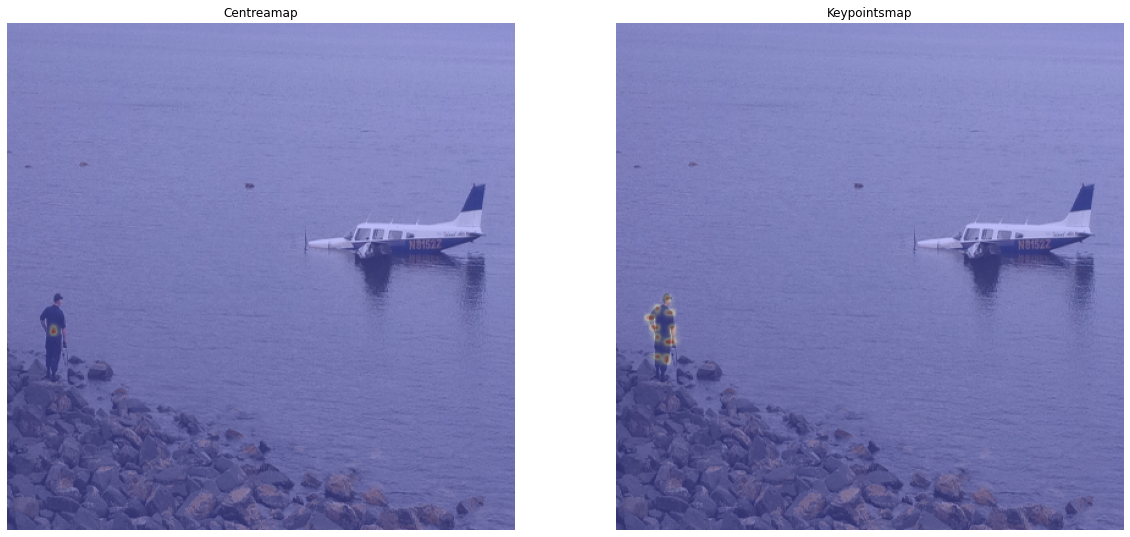

In [5]:
i = 6

sample = ((img[i].numpy() + 1) * 127.5).astype('uint8')
centermap = cv2.resize(y2[i,:,0].numpy().reshape(104, 104), (416, 416))
keymap = cv2.resize(y2[i,:,1:].numpy().sum(axis=-1).reshape(104, 104), (416, 416))

fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(20)

axs[0].imshow(sample, alpha=.75)
axs[0].imshow(centermap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[0].set_title("Centreamap")
axs[0].axis('off')

axs[1].imshow(sample, alpha=.75)
axs[1].imshow(keymap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[1].set_title("Keypointsmap")
axs[1].axis('off')

(-0.5, 415.5, 415.5, -0.5)

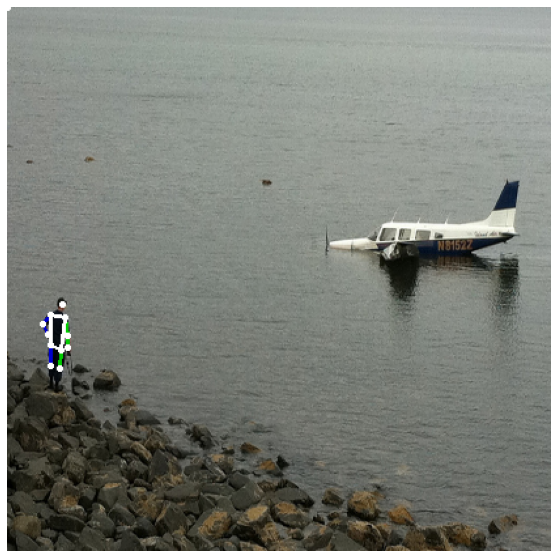

In [6]:
i = 6

sample = ((img[i].numpy() + 1) * 127.5).astype('uint8')
labels = y1[i, :, :3].numpy()
labels = labels[:, [1,2,0]]

sample = draw_keypoints(sample, labels, .5)

fig = plt.figure(figsize=(10,10))

plt.imshow(sample)
plt.axis('off')

## 2. Test Horizontal and Vertical Shift agmentations

In [7]:
filePaths = list(paths.list_files("../test/tfrecs/"))

shift_ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = shift_aug,
    roi_thresh = -1
    )


In [8]:
for img, (y1, y2) in shift_ds:
    print(img.shape)
    print(y1.shape)
    print(y2.shape)

(10, 416, 416, 3)
(10, 17, 5)
(10, 10816, 18)


(-0.5, 415.5, 415.5, -0.5)

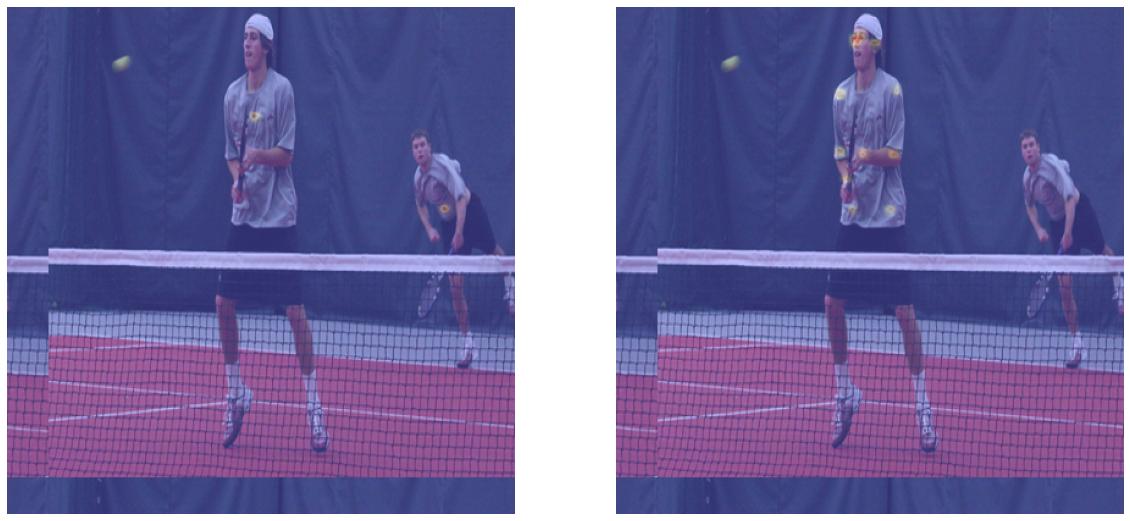

In [9]:
i = 6

sample = ((img[i].numpy() + 1) * 127.5).astype('uint8')
centermap = cv2.resize(y2[i,:,0].numpy().reshape(104, 104), (416, 416))
keymap = cv2.resize(y2[i,:,1:].numpy().sum(axis=-1).reshape(104, 104), (416, 416))

fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(20)

axs[0].imshow(sample, alpha=.75)
axs[0].imshow(centermap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[0].axis('off')

axs[1].imshow(sample, alpha=.75)
axs[1].imshow(keymap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[1].axis('off')

(-0.5, 415.5, 415.5, -0.5)

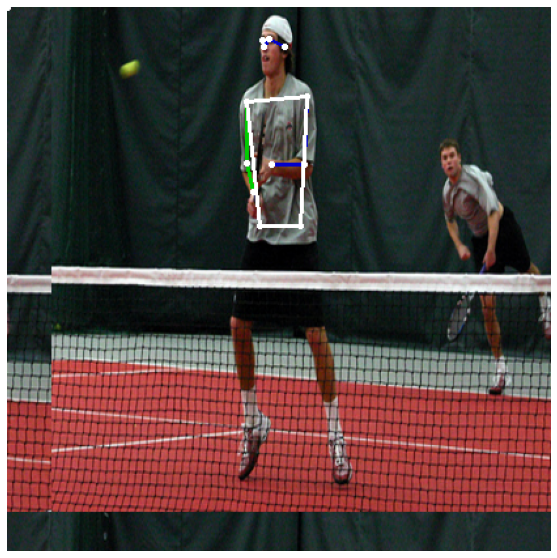

In [10]:
i = 6

sample = ((img[i].numpy() + 1) * 127.5).astype('uint8')
labels = y1[i, :, :3].numpy()
labels = labels[:, [1,2,0]]

sample = draw_keypoints(sample, labels, .5)

fig = plt.figure(figsize=(10,10))

plt.imshow(sample)
plt.axis('off')

## 3. Test Horizontal Flip Augmentation

In [13]:
ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 1,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = -1,
    debug=True
    )

flip_ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 1,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = flip_aug,
    roi_thresh = -1,
    debug=True
    )

Text(0.5, 1.0, 'Flipped')

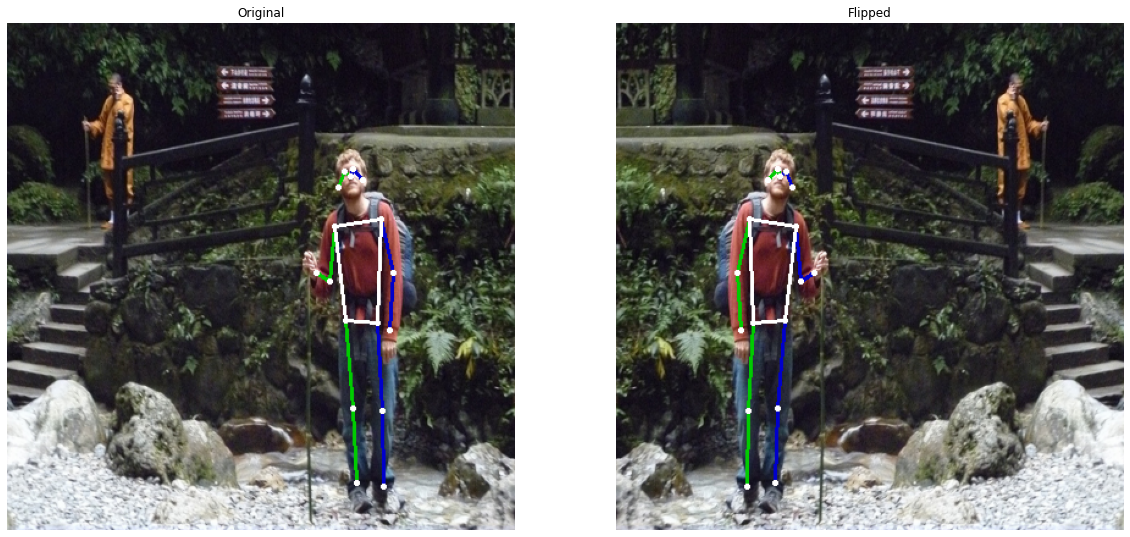

In [14]:
i=3

for f_img, (y1, _) in flip_ds.take(i):
    f_sample = ((f_img[0].numpy() + 1) * 127.5).astype('uint8')
    c_kpts = y1[0, :, :3].numpy()
    c_kpts = c_kpts[:, [1,2,0]]

f_sample = draw_keypoints(f_sample, c_kpts, .1)    

for img, (y1, _) in ds.take(i):
    sample = ((img[0].numpy() + 1) * 127.5).astype('uint8')
    c_kpts = y1[0, :, :3].numpy()
    c_kpts = c_kpts[:, [1,2,0]]

sample = draw_keypoints(sample, c_kpts, .1)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(20)

axs[0].imshow(sample)
axs[0].axis('off')
axs[0].set_title("Original")

axs[1].imshow(f_sample)
axs[1].axis('off')
axs[1].set_title("Flipped")

## 4. Test Focus on ROI

In [4]:
ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = -1,
    debug=True
    )

roi_ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 1,
    debug=True
    )

2022-10-31 15:05:33.448729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
for img, (y1, y2) in ds.take(1):
    print(img.shape)
    print(y1.shape)
    print(y2.shape)

print()
for ag_img, (ag_y1, ag_y2) in roi_ds.take(1):
    print(ag_img.shape)
    print(ag_y1.shape)
    print(ag_y2.shape)

(10, 416, 416, 3)
(10, 17, 5)
(10, 10816, 18)

(10, 416, 416, 3)
(10, 17, 5)
(10, 10816, 18)


(-0.5, 415.5, 415.5, -0.5)

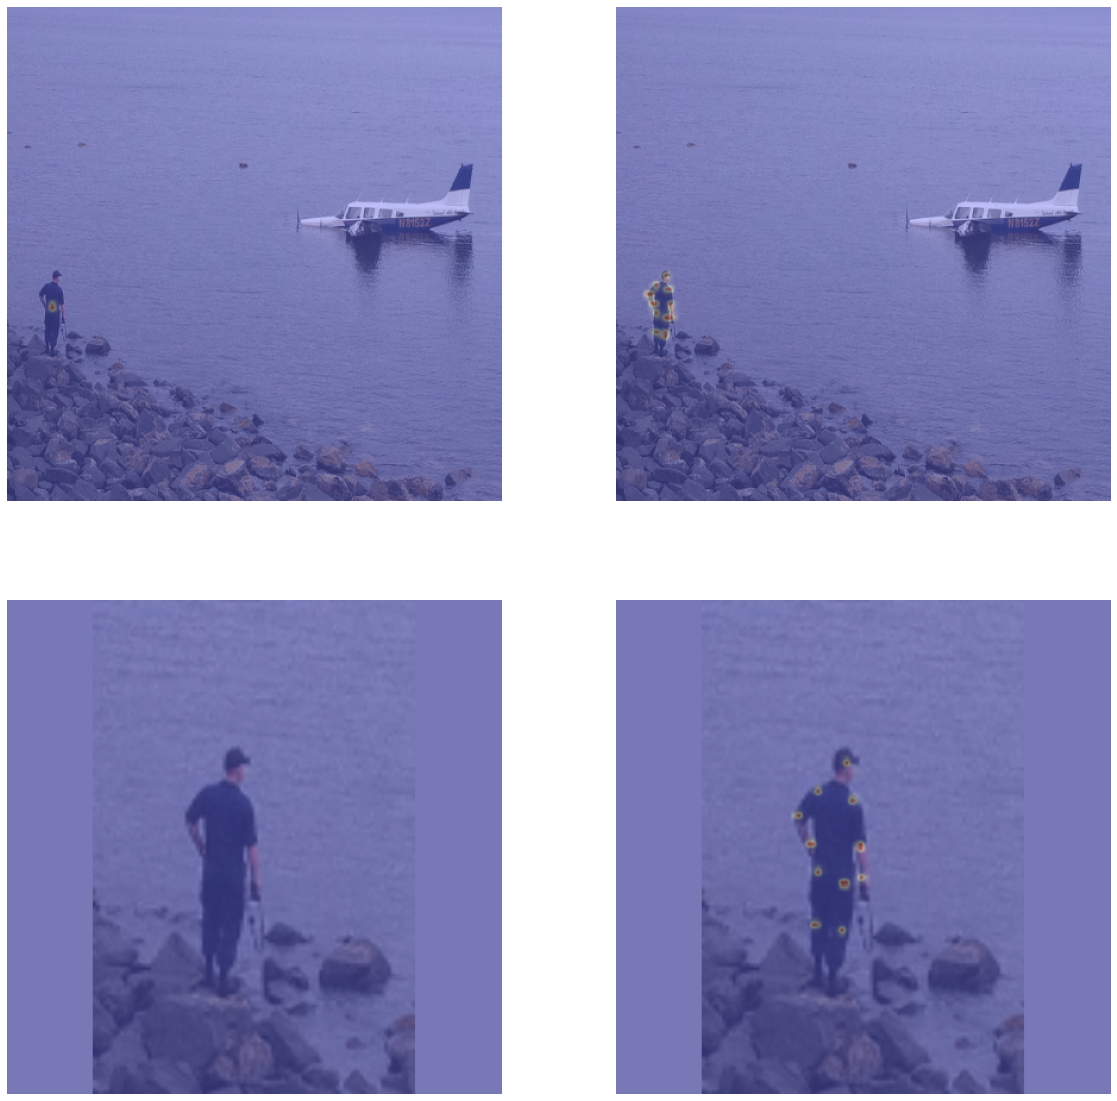

In [19]:
i = 6

sample = ((img[i].numpy() + 1) * 127.5).astype('uint8')
centermap = cv2.resize(y2[i,:,0].numpy().reshape(104, 104), (416, 416))
keymap = cv2.resize(y2[i,:,1:].numpy().sum(axis=-1).reshape(104, 104), (416, 416))

ag_sample = ((ag_img[i].numpy() + 1) * 127.5).astype('uint8')
ag_centermap = cv2.resize(ag_y2[i,:,0].numpy().reshape(104, 104), (416, 416))
ag_keymap = cv2.resize(ag_y2[i,:,1:].numpy().sum(axis=-1).reshape(104, 104), (416, 416))

fig, axs = plt.subplots(2, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

axs[0,0].imshow(sample, alpha=.75)
axs[0,0].imshow(centermap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[0,0].axis('off')

axs[0,1].imshow(sample, alpha=.75)
axs[0,1].imshow(keymap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[0,1].axis('off')

axs[1,0].imshow(ag_sample, alpha=.75)
axs[1,0].imshow(ag_centermap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[1,0].axis('off')

axs[1,1].imshow(ag_sample, alpha=.75)
axs[1,1].imshow(ag_keymap, alpha=.25, cmap=mpl.colormaps['bwr'])
axs[1,1].axis('off')